# 2. Estimating Underperformance

### Data
Use the returns on the S&P 500 ($r^m$) and 1-month T-bills, ($r^f$) provided in `barnstable_analysis_data.xlsx`.

- Data goes through `END_YR=2024`.

Barnstable’s estimates of mean and volatility are based on the subsample of 1965 to 1999.

- We consider this subsample, as well as 2000-{END_YR}, as well as the full sample of 1926-{END_YR}.

### Notation
- $r$ = level return rates

- $R$ = cumulative return factor

- $\text{r}$ = log return rates

$$
R = 1 + r
$$

$$
\text{r} = \ln(1 + r) = \ln(R)
$$

In [39]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [40]:
data = pd.read_excel("../data/barnstable_analysis_data.xlsx", sheet_name = "data").set_index("date")
data.head()

,SPX,TB1M
date,,
1926-01-30,-0.001783,0.003061
1926-02-27,-0.033297,0.002612
1926-03-31,-0.057708,0.002601
1926-04-30,0.038522,0.002270
1926-05-28,0.013623,0.002691


In [ ]:
sample_1965_1999 = data[(data.index.year >= 1965) & (data.index.year <= 1999)]
sample_2000_2024 = data[(data.index.year >= 2000) & (data.index.year <= 2024)]
sample_1926_2024 = data[(data.index.year >= 1926) & (data.index.year <= 2024)]

## 1. Summary Statistics

Report the following (annualized) statistics.

In [44]:
def CalcLevelReturnsSTD(returns: pd.Series):
    levelReturns = (1 + returns).prod()
    numYear = len(returns) / 12
    mean = levelReturns ** (1 / numYear) - 1
    std = returns.std() * np.sqrt(12)
    return (mean, std)

def LevelandLogReturns(data: pd.DataFrame):
    data = data.dropna()
    market, rf = data["SPX"], data["TB1M"]
    excessReturn = market - rf
    
    # Level Returns
    ## SPX
    marketLevelMean, marketLevelSTD = CalcLevelReturnsSTD(market)
    ## Risk Free
    rfLevelMean, rfLevelSTD = CalcLevelReturnsSTD(rf)
    ## Excess Returns
    excessLevelMean, excessLevelSTD = CalcLevelReturnsSTD(excessReturn)
    
    # Log Returns
    marketLogReturns = np.log1p(market)
    rfLogReturns = np.log1p(rf)
    
    ## SPX
    marketLogMean = marketLogReturns.mean() * 12
    marketLogSTD = marketLogReturns.std() * np.sqrt(12)
    
    ## Risk Free
    rfLogMean = rfLogReturns.mean() * 12
    rfLogSTD = rfLogReturns.std() * np.sqrt(12)

    ## Excess Return = np.log1p(SPX) - np.log1p(Risk Free)
    excessLogReturns = marketLogReturns - rfLogReturns
    excessLogMean = excessLogReturns.mean() * 12
    excessLogSTD = excessLogReturns.std() * np.sqrt(12)
    
    return (marketLevelMean, marketLevelSTD, rfLevelMean, rfLevelSTD, excessLevelMean, excessLevelSTD, marketLogMean, marketLogSTD, rfLogMean, rfLogSTD, excessLogMean, excessLogSTD)

In [45]:
def CreateSummarStats(data: pd.DataFrame):
    marketLevelMean, marketLevelSTD, rfLevelMean, rfLevelSTD, excessLevelMean, excessLevelSTD, marketLogMean, marketLogSTD, rfLogMean, rfLogSTD, excessLogMean, excessLogSTD = LevelandLogReturns(data)
    result = pd.DataFrame({
        "Mean": [marketLevelMean, rfLevelMean, excessLevelMean, marketLogMean, rfLogMean, excessLogMean],
        "Vol": [marketLevelSTD, rfLevelSTD, excessLevelSTD, marketLogSTD, rfLogSTD, excessLogSTD]
    })
    result.index = pd.MultiIndex.from_tuples([
            ('levels', 'r^m'), ('levels', 'r̃^m'), ('levels', 'r^f'),
            ('logs', 'r^m'), ('logs', 'r̃^m'), ('logs', 'r_f')
    ])
    return result

In [46]:
result_1965_1999 = CreateSummarStats(sample_1965_1999)
result_2000_2024 = CreateSummarStats(sample_2000_2024)
result_1926_2024 = CreateSummarStats(sample_1926_2024)
result2_1 = pd.DataFrame({
    ('1965-1999', 'mean'): result_1965_1999['Mean'],
    ('1965-1999', 'vol'): result_1965_1999['Vol'],
    ('2000-2024', 'mean'): result_2000_2024['Mean'],
    ('2000-2024', 'vol'): result_2000_2024['Vol'],
    ('1926-2024', 'mean'): result_1926_2024['Mean'],
    ('1926-2024', 'vol'): result_1926_2024['Vol']
}).round(4)

result2_1

1965-1999         2000-2024         1926-2024        
                 mean     vol      mean     vol      mean     vol
levels r^m     0.1257  0.1495    0.0785  0.1528    0.1024  0.1870
       r̃^m    0.0632  0.0072    0.0176  0.0056    0.0324  0.0085
       r^f     0.0588  0.1502    0.0599  0.1531    0.0679  0.1873
logs   r^m     0.1184  0.1497    0.0756  0.1538    0.0975  0.1863
       r̃^m    0.0613  0.0071    0.0174  0.0055    0.0318  0.0085
       r_f     0.0571  0.1504    0.0581  0.1540    0.0656  0.1866

- Return: `1965-1999` > `1926-2024` > `2000-2024`
- Volatility: `1926-2024` > `2000-2024` > `1965-1999`

- Because of the volatility drag of financial data, **geometric mean** (log return) is always less than the **arithmetic mean** (level return)

---

## 2. Probability of Underperformance

Recall the following:

- If $x \sim N(\mu_x, \sigma^2_x)$, then
$$
\mathbb{P}[x < \ell] = \Phi_N(L)
$$
where $\mathbb{L} = \frac{l-\mu_x}{\sigma_x}$ and $\Phi_N$ denotes the standard normal cdf

- Remember that cumulative log returns are simply the sum of the single-period log returns:

$$
\mathbf{r}^{m}_{t,t+h} \equiv \sum_{i=1}^{h} \mathbf{r}^{m}_{t+i}
$$

- It will be convenient to use and denote sample averages. We use the following notation for an $h$-period average ending at time $t+h$:

$$
\mathbf{\bar{r}}^{m}_{t,t+h} = \frac{1}{h} \sum_{i=1}^{h} \mathbf{r}^{m}_{t+i}
$$

Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return:

$$
\mathbb{P}[R^m_{t, t+h} < R^f_{t, t+h}]
$$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.

### 2.1

Calculate the probability using the subsample 1965-1999.

In [28]:
def Underperformance(returns: pd.DataFrame, horizon: int):
    spxLogReturn = np.log1p(returns["SPX"])
    tbillLogReturn = np.log1p(returns["TB1M"])
    excessReturn = spxLogReturn - tbillLogReturn

    excessReturnMean = excessReturn.mean()
    excessReturnSTD = excessReturn.std()
    
    month = horizon * 12
    mean = excessReturnMean * month
    std = excessReturnSTD * np.sqrt(month)
    
    l = (0 - mean) / std
    prob = norm.cdf(l)
    
    return round(float(prob), 4)

In [29]:
Underperformance(sample_1965_1999, 35)

0.0124

### 2.2
Report the precise probability for $h=15$ and $h=30$ years.

In [30]:
prob15 = Underperformance(sample_1965_1999, 15)
prob30 = Underperformance(sample_1965_1999, 30)

print(f"Probability of Underperformance for 15 yr horizon: {prob15}")
print(f"Probability of Underperformance for 30 yr horizon: {prob30}")

Probability of Underperformance for 15 yr horizon: 0.0708
Probability of Underperformance for 30 yr horizon: 0.0188


### 2.3
Plot the probability as a function of the investment horizon, $h$, for $0 < h \leq 30$  years.

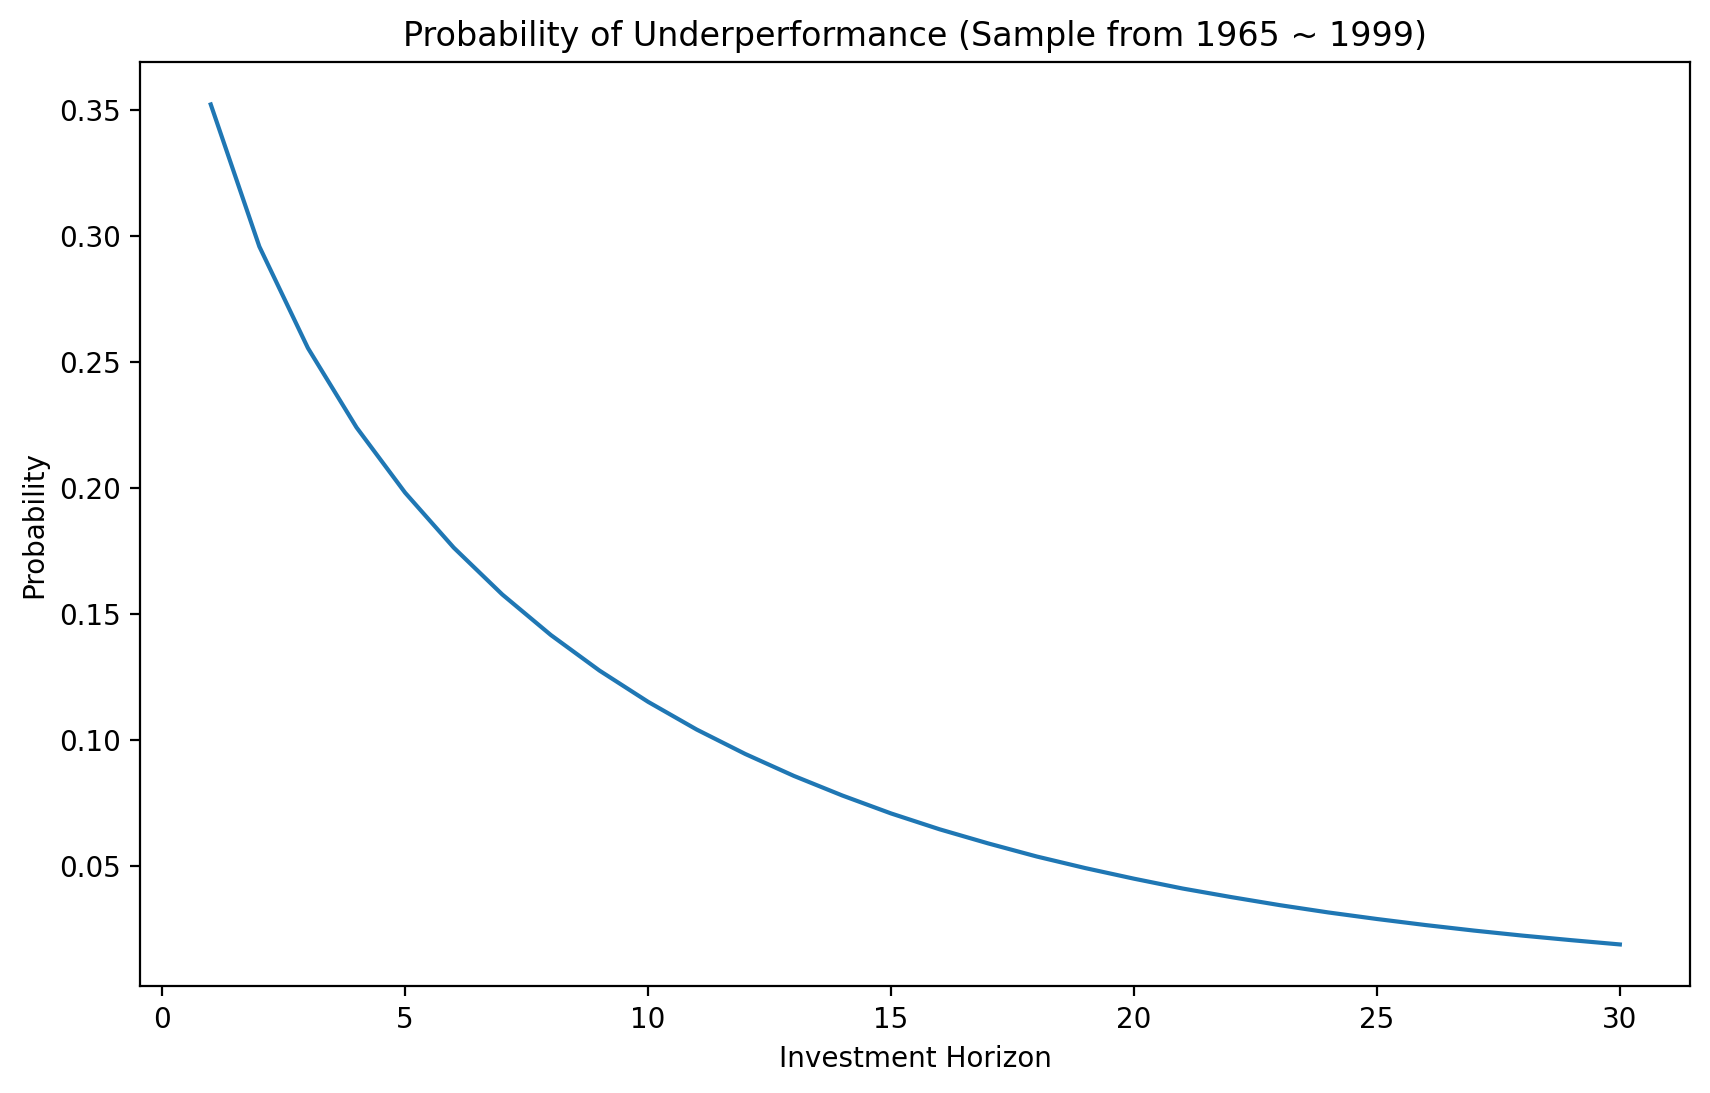

In [49]:
prob = list()

for i in range(31):
    prob.append(Underperformance(sample_1965_1999, i))

plt.figure(figsize = (10, 6))
plt.plot(prob)
plt.title("Probability of Underperformance (Sample from 1965 ~ 1999)")
plt.xlabel("Investment Horizon")
plt.ylabel("Probability")
plt.show()

The longer you stay invested in the market, the lower your chance of underperforming the risk-free rate

Hint: The probability can be expressed as:

$$
p(h) = \Phi_N(-\sqrt(h)SR)
$$

where $SR$ denotes the sample Sharpe ratio of log market returns.

$$
l = \frac{0 - (h*\mu_{excess\ log\ return})}{\sqrt(h) * \sigma_{excess\ log\ return}} = -\sqrt(h)\frac{\mu_{excess\ log\ return}}{\sigma_{excess\ log\ return}} = -\sqrt(h) * SR
$$

---

## 3. Full Sample Analysis

Use the sample 1965-{END_YR} to reconsider the 30-year probability. As of the end of {END_YR}, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R^m_{t,t+h}$ underperforming $R^f_{t,t+h}$ for $0 < h \leq 30$

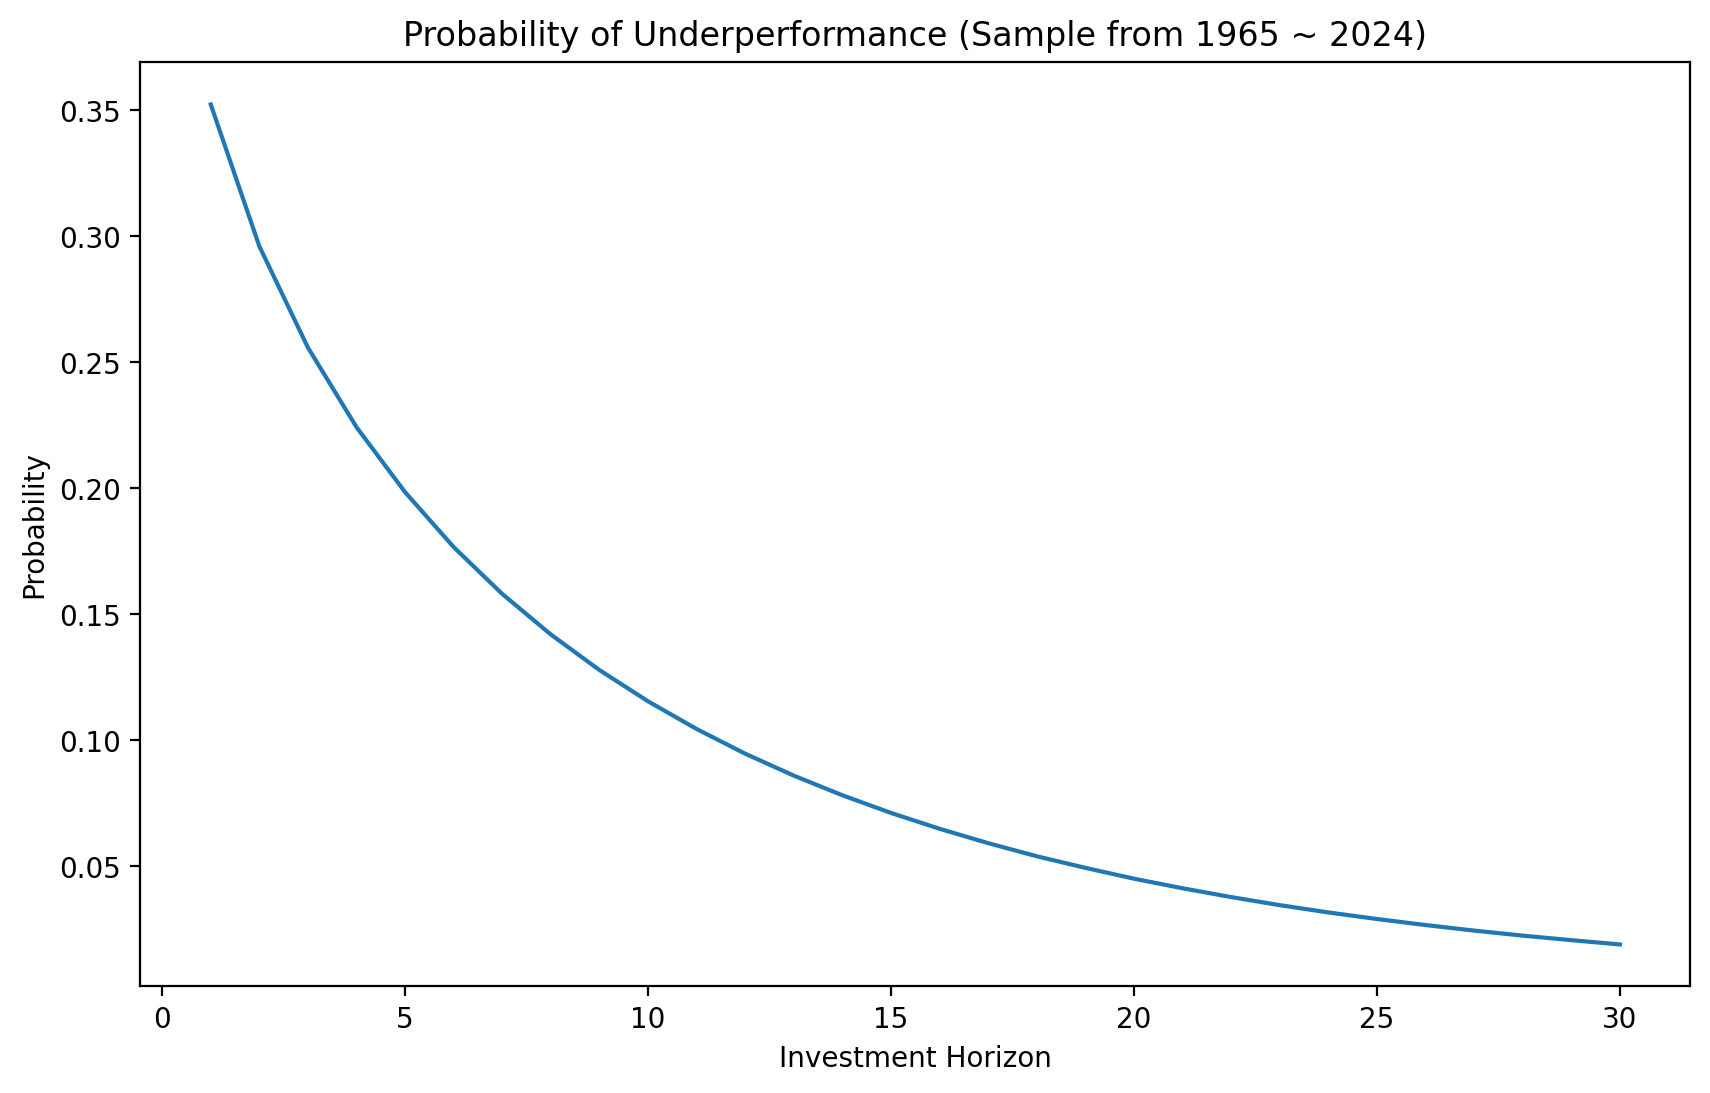

In [50]:
sample_1965_2024 = data[(data.index.year >= 1965) & (data.index.year <= 2024)]
prob = list()

for i in range(31):
    prob.append(Underperformance(sample_1965_2024, i))

plt.figure(figsize = (10, 6))
plt.plot(prob)
plt.title("Probability of Underperformance (Sample from 1965 ~ 2024)")
plt.xlabel("Investment Horizon")
plt.ylabel("Probability")
plt.show()

---

## 4. In-Sample Estimate of Out-of-Sample Likelihood

Let’s consider how things turned out relative to Barnstable’s 1999 expectations.

What was the probability (based on the 1999 estimate of $\mu$) that the `h`-year market return, $R^m_{t,t+h}$, would be smaller than that realized in `2000-{END_YR}`?

Hint: You can calculate this as:

$$
p = \Phi_N \left( \sqrt{h} \frac{\bar{\mathbf{r}}_{\text{out-of-sample}} - \bar{\mathbf{r}}_{\text{in-sample}}}{\sigma_{\text{in-sample}}} \right)
$$

where “in-sample” denotes 1965-1999 and “out-of-sample” denotes 2000-{END_YR}.